# Imports

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '0,3,6,7'

In [2]:
# import sys
# sys.path.insert(0, '/net/per920a/export/das14a/satoh-lab/shiv25/spot_fake/godin_files/')

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from os import listdir
from sklearn.metrics import accuracy_score

import tensorflow as tf
import tensorflow_hub as hub  #pip install tensorflow_hub
import os
from tokenization import FullTokenizer
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K
# from keras import backend as K
# Initialize session
# sess = tf.Session()
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) #command to run codeon multiple gpu



# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

from keras_lr_finder import LRFinder
import talos as ta
from pprint import pprint
from talos import live
tf.logging.set_verbosity(tf.logging.ERROR)
from random import choice
import gc


W0603 14:45:59.656936 140683784238912 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
Using TensorFlow backend.


In [112]:
from talos.model.normalizers import lr_normalizer

In [4]:
np.random.seed(42)
tf.set_random_seed(42)

# Read data

In [5]:
!ls ../dataset/twitter_final/mediaeval2016/

ls: cannot access '../dataset/twitter_final/mediaeval2016/': No such file or directory


In [6]:
def get_df(file):
    return pd.read_csv(file,sep = '\t')

In [7]:
train_df = get_df('dataset/twitter_final/mediaeval2016/train_posts.txt')
test_df = get_df('dataset/twitter_final/mediaeval2016/test_posts.txt')

In [8]:
def return_first_image(row):
    return row['image_id(s)'].split(',')[0].strip()

In [9]:
train_df['first_image_id'] = train_df.progress_apply (lambda row: return_first_image(row),axis=1)

In [10]:
train_df

,post_id,post_text,user_id,image_id(s),username,timestamp,label,first_image_id
0,324597532548276224,Don't need feds to solve the #bostonbombing wh...,886672620,"boston_fake_03,boston_fake_35",SantaCruzShred,Wed Apr 17 18:57:37 +0000 2013,fake,boston_fake_03
1,325145334739267584,PIC: Comparison of #Boston suspect Sunil Tripa...,21992286,boston_fake_23,Oscar_Wang,Fri Apr 19 07:14:23 +0000 2013,fake,boston_fake_23
2,325152091423248385,I'm not completely convinced that it's this Su...,16428755,boston_fake_34,jamwil,Fri Apr 19 07:41:14 +0000 2013,fake,boston_fake_34
3,324554646976868352,Brutal lo que se puede conseguir en colaboraci...,303138574,"boston_fake_03,boston_fake_35",rubenson80,Wed Apr 17 16:07:12 +0000 2013,fake,boston_fake_03
4,324315545572896768,4chan and the bombing. just throwing it out th...,180460772,boston_fake_15,Slimlenny,Wed Apr 17 00:17:06 +0000 2013,fake,boston_fake_15
5,324581777614180352,4chan thinks they found pictures of the bomber...,46224814,boston_fake_08,iamyadvinder,Wed Apr 17 17:55:00 +0000 2013,fake,boston_fake_08
6,324665423956176896,"Ola ke ase, investigando las bombas de Boston ...",90735851,boston_fake_35,rcr866,Wed Apr 17 23:27:23 +0000 2013,fake,boston_fake_35
7,325464125868216321,4chan ThinkTank - Imgur http://t.co/hQt2fhxE48,142785938,"boston_fake_03,boston_fake_35",GlebGgs,Sat Apr 20 04:21:09 +0000 2013,fake,boston_fake_03
8,325099014355820544,@DLoesch have you seen this? Bomber #2 looks ...,21769179,boston_fake_13,larrygloverlive,Fri Apr 19 04:10:19 +0000 2013,fake,boston_fake_13
9,325705653026975744,da 4chan think tank BOSTON http://t.co/0ZbKMA...,51410043,"boston_fake_03,boston_fake_35",IsraelTucker,Sat Apr 20 20:20:53 +0000 2013,fake,boston_fake_03


In [11]:
test_df.shape

(2177, 7)

In [12]:
train_df.shape

(15629, 8)

In [13]:
images_train_dataset = [i for i in train_df['first_image_id'].tolist()]
images_train_folder = [i.split('.')[0].strip() for i in listdir('dataset/twitter_final/mediaeval2016/images_train/')]
images_train_not_available = set(images_train_dataset)-set(images_train_folder)
images_train_not_available

{'boston_fake_35',
 'eclipse_video_01',
 'sandy_real_09',
 'sandy_real_10',
 'sandy_real_4',
 'sandy_real_6',
 'sandy_real_90',
 'syrianboy_1',
 'varoufakis_1'}

In [14]:
images_test_dataset = [i.split(',')[0].strip() for i in test_df['image_id'].tolist()]
images_test_folder = [i.split('.')[0].strip() for i in listdir('dataset/twitter_final/mediaeval2016/images_test/')]
images_test_not_available = set(images_test_dataset)-set(images_test_folder)
images_test_not_available

{'airstrikes_1',
 'american_soldier_quran_1',
 'ankara_explosions_1',
 'ankara_explosions_2',
 'ankara_explosions_3',
 'attacks_paris_16',
 'attacks_paris_24',
 'attacks_paris_7',
 'boko_haram_1',
 'brussels_car_metro_1',
 'brussels_car_metro_2',
 'brussels_car_metro_3',
 'brussels_explosions_1',
 'brussels_explosions_2',
 'brussels_explosions_3',
 'convoy_explosion_turkey_1',
 'convoy_explosion_turkey_2',
 'convoy_explosion_turkey_3',
 'donald_trump_attacker_1',
 'eagle_kid_1',
 'immigrants_1',
 'immigrants_2',
 'immigrants_3',
 'immigrants_4',
 'immigrants_5',
 'immigrants_6',
 'immigrants_7',
 'immigrants_8',
 'isis_children_1',
 'isis_children_2',
 'nazi_submarine_2',
 'pope_francis_1',
 'snowboard_girl_1',
 'snowboard_girl_2',
 'syrian_children_2'}

In [15]:
images_train_not_available.add('boston_fake_10')

In [16]:
train_df = train_df[~train_df['first_image_id'].isin(images_train_not_available)]
test_df = test_df[~test_df['image_id'].isin(images_test_not_available)]

In [17]:
test_df.shape

(1040, 7)

In [18]:
train_df.shape

(13407, 8)

In [19]:
train_text = train_df['post_text'].tolist()
test_text = test_df['post_text'].tolist()

train_images = [i for i in train_df['first_image_id'].tolist()]
test_images = [i.split(',')[0].strip() for i in test_df['image_id'].tolist()]

trainY = train_df['label'].tolist()
trainY = [1 if i=='real' else 0 for i in trainY]

testY = test_df['label'].tolist()
testY = [1 if i=='real' else 0 for i in testY]

In [20]:
len(train_text),len(train_images),len(trainY),len(test_text),len(test_images),len(testY)

(13407, 13407, 13407, 1040, 1040, 1040)

In [21]:
# calculate the maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])

maximum length: 26


(array([   0.,    3.,  268.,  409.,  581.,  563.,  644.,  602.,  765.,
        2583., 2320.,  777., 1717., 1117., 1042.,   16.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 12, 15, 16, 18, 20, 25, 30]),
 <a list of 16 Patch objects>)

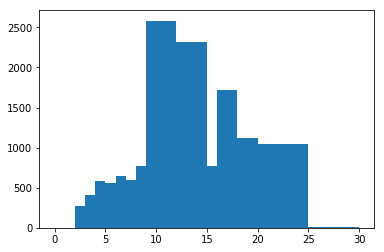

In [22]:
print("maximum length:", max_length(train_text))
plt.hist([len(s.split()) for s in train_text],bins=[0,1,2,3,4,5,6,7,8,9,12,15,16,18,20,25,30])

In [23]:
l=[len(s.split()) for s in train_text]
count=0.0
for i in l:
    if i>22:
        count+=1
print(count,len(l))
print(count/len(l))

113.0 13407
0.008428432908182293


In [24]:
max_seq_length=23

In [25]:
# trainY.count('real'),trainY.count('fake'),testY.count('real'),testY.count('fake')

# Text part

In [26]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, trainY)
test_examples = convert_text_to_examples(test_text, testY)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, trainY 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)
(test_input_ids, test_input_masks, test_segment_ids, testY
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

# Image Part

In [27]:
length = 224
width = 224
channels = 3

In [28]:
def read_and_process_image(list_of_images):
    X = [] 
    for image in tqdm(list_of_images):
#         print(image)
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (length,width), interpolation=cv2.INTER_CUBIC))  
    return X

In [29]:
images = listdir('dataset/twitter_final/mediaeval2016/images_train/')
images.extend(listdir('dataset/twitter_final/mediaeval2016/images_test/'))
jpg = []
png=[]
jpeg=[]
gif = []

for i in images:
    name,ext = i.split('.')[0],i.split('.')[-1]
    eval(ext).append(name)

In [30]:
def get_extension_of_file(file_name):
    if file_name in jpg:
        return '.jpg'
    elif file_name in png:
        return '.png'
    elif file_name in jpeg:
        return '.jpeg'
    else:
        return '.gif'

In [31]:
train_images = ['dataset/twitter_final/mediaeval2016/images_train/'+i+get_extension_of_file(i) for i in train_images]
test_images = ['dataset/twitter_final/mediaeval2016/images_test/'+i+get_extension_of_file(i) for i in test_images]

In [32]:
# train_imagesX = read_and_process_image(train_images)
# test_imagesX = read_and_process_image(test_images)

In [33]:
# np.save('train_imagesX.npy', train_imagesX)
# np.save('test_imagesX.npy', test_imagesX)

In [34]:
train_imagesX = np.load('train_imagesX.npy')
test_imagesX = np.load('test_imagesX.npy')

In [35]:
train_imagesX = np.rollaxis(train_imagesX, 3, 1)
test_imagesX = np.rollaxis(test_imagesX,3,1)

# The Model

In [36]:
class BertLayer(tf.layers.Layer):
    def __init__(self, n_fine_tune_layers=10, **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            bert_path,
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )

        trainable_vars = self.bert.variables

        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]

        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers :]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
            
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            "pooled_output"
        ]
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [37]:
def initialize_vars(sess):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) #command to run codeon multiple gpu
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [38]:
# base = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(3,224,224))
# base.trainable=False
first = True

In [181]:
#text model
def news_model(x_train, y_train, x_val, y_val, params):
    
#     pprint(params)
    try:
        del model
    except:
        pass
    K.clear_session()
    gc.collect()
    
    with tf.device('/cpu:0'):
        bert_base = BertLayer()
        bert_base.trainable= params['bert_trainable']

        in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
        in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
        in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
        bert_inputs = [in_id, in_mask, in_segment]
        bert_output = bert_base(bert_inputs)

        if params['text_no_hidden_layer']>0:
            for i in range(params['text_no_hidden_layer']):
                bert_output = tf.keras.layers.Dense(params['text_hidden_neurons'], activation='relu')(bert_output)
                bert_output = tf.keras.layers.Dropout(params['dropout'])(bert_output)

        text_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(bert_output)

        #image model
        conv_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(3,224,224))
        conv_base.trainable=False
#         conv_base = base

        input_image = tf.keras.layers.Input(shape=(3,224,224))
        base_output = conv_base(input_image)
        flat = tf.keras.layers.Flatten()(base_output)

        if params['vis_no_hidden_layer']>0:
            for i in range(params['vis_no_hidden_layer']):
                flat = tf.keras.layers.Dense(params['vis_hidden_neurons'], activation='relu')(flat)
                flat = tf.keras.layers.Dropout(params['dropout'])(flat)

        visual_repr = tf.keras.layers.Dense(params['repr_size'],activation='relu')(flat)


        #classifier
        combine_repr = tf.keras.layers.concatenate([text_repr, visual_repr])
        com_drop=tf.keras.layers.Dropout(params['dropout'])(combine_repr)

        if params['final_no_hidden_layer']>0:
            for i in range(params['final_no_hidden_layer']):
                com_drop = tf.keras.layers.Dense(params['final_hidden_neurons'], activation='relu')(com_drop)
                com_drop=tf.keras.layers.Dropout(params['dropout'])(com_drop)

        prediction = tf.keras.layers.Dense(1,activation='sigmoid')(com_drop)

        model = tf.keras.models.Model(inputs=[in_id,in_mask,in_segment,input_image], outputs=prediction)

    model = tf.keras.utils.multi_gpu_model(model,gpus=4)
    
#     if params['optimizer'] == 'adam':
#         opt = tf.keras.optimizers.Adam(lr=0.0005)
#     else:
#         opt = tf.keras.optimizers.RMSprop(lr=0.00005)
        
#     model.compile(loss='binary_crossentropy', optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])), metrics=['accuracy'])
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'](lr=params['lr']), metrics=['accuracy'])
    initialize_vars(sess)
    
    out = model.fit(x_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    verbose=0,
                    shuffle=True,
                    validation_data=[x_val, y_val],callbacks=[live()])
    
    return out, model



In [40]:
params = {
    'bert_trainable' :[False,True],
    'text_no_hidden_layer':(0,3,3),
    'text_hidden_neurons':[768,400,32],
    'dropout':(0.3,0.7,4),
    'repr_size':[32],
    'vis_no_hidden_layer':(0,3,3),
    'vis_hidden_neurons':[4096,2742,1388,32],
    'final_no_hidden_layer':(0,3,3),
    'final_hidden_neurons':[64,35,5],
    'optimizer':['adam','rmsprop'],
    'batch_size':[512],
    'epochs':[10]
}

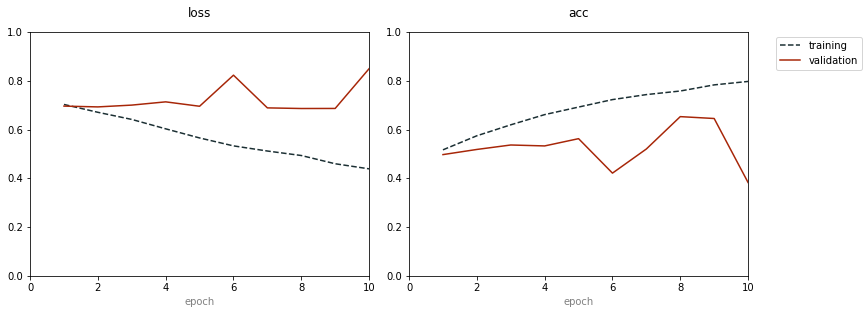

100%|██████████| 31/31 [3:36:11<00:00, 409.80s/it]


In [41]:
h = ta.Scan([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY, params=params,
            model=news_model,
            dataset_name='twitter_fake_news',
            experiment_no='1',
            x_val=[test_input_ids, test_input_masks, test_segment_ids,test_imagesX],
            y_val=testY,
            grid_downsample=.002)

## Lets look at Hyper parameter experiment 1 

In [54]:
r = ta.Reporting(h)

In [80]:
r.high('val_acc')

0.7230769230769231

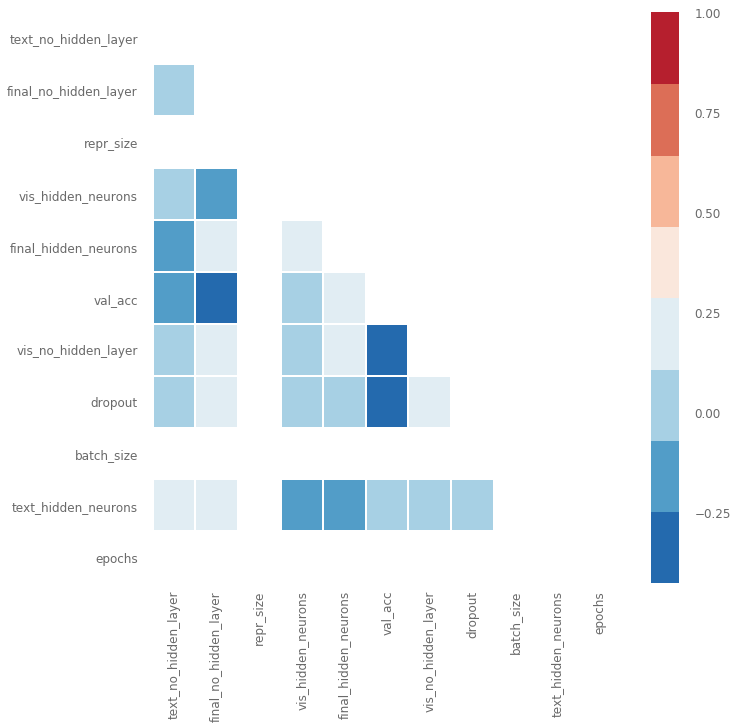

In [79]:
r.plot_corr()

bert_trainable
text_no_hidden_layer
text_hidden_neurons
dropout
repr_size
vis_no_hidden_layer
vis_hidden_neurons
final_no_hidden_layer
final_hidden_neurons
optimizer
batch_size
epochs


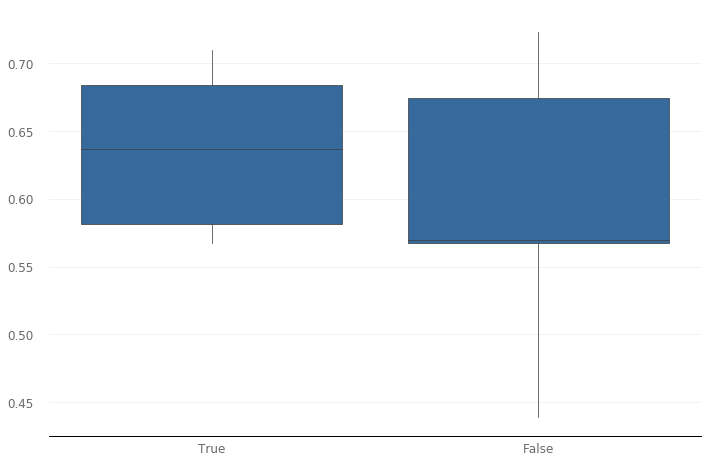

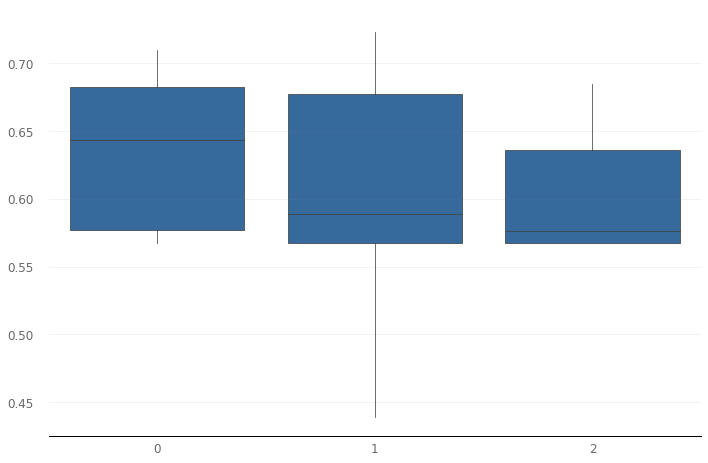

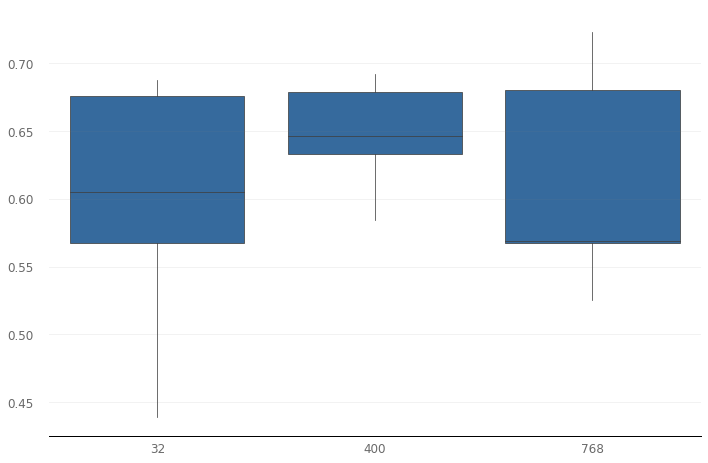

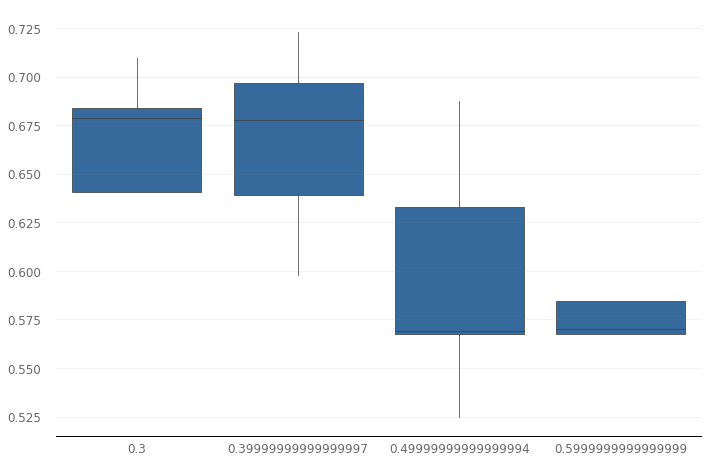

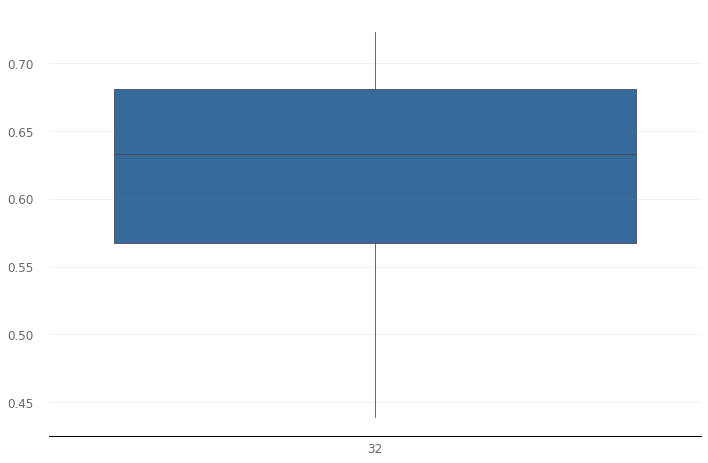

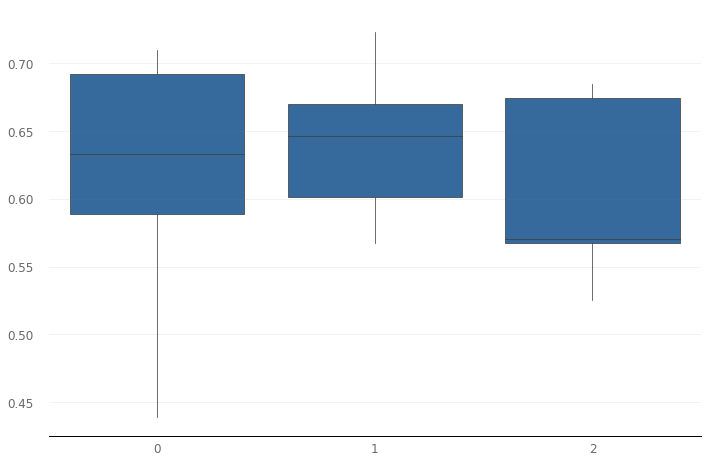

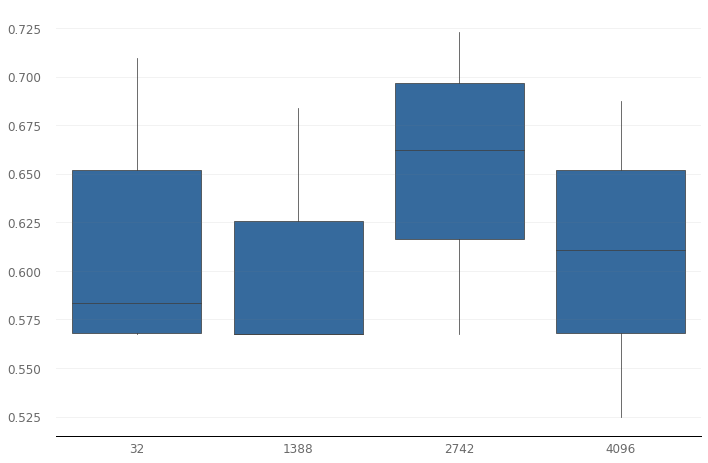

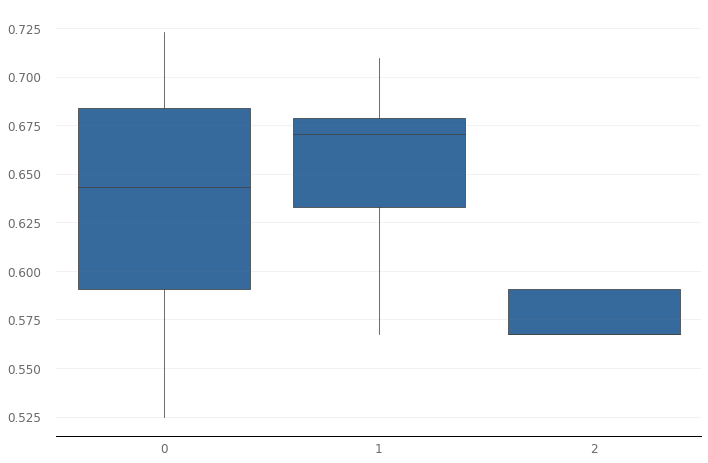

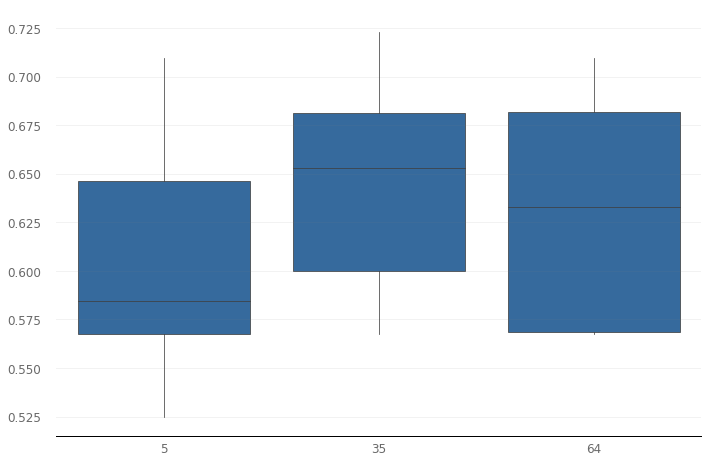

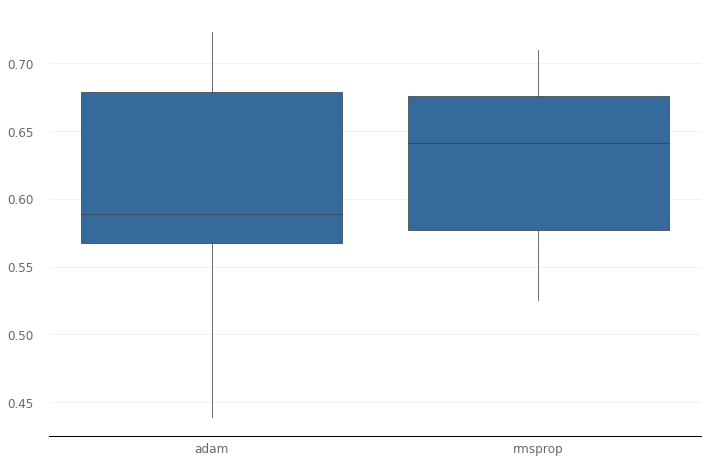

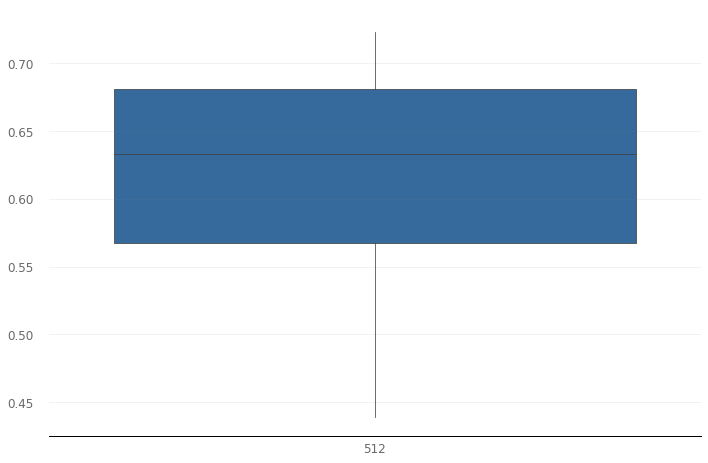

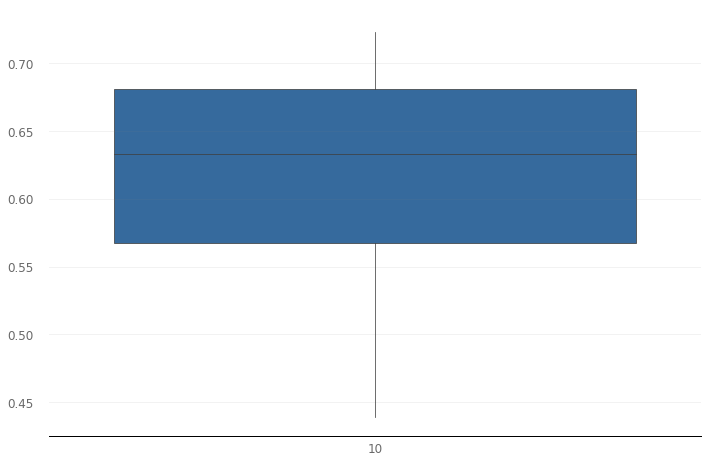

In [77]:
for k in params.keys():
    print(k)
    r.plot_box(y='val_acc',x=k)

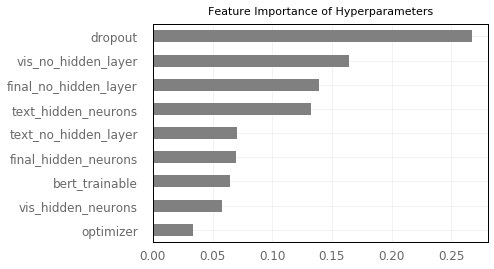

In [93]:
from sklearn.preprocessing import MinMaxScaler

X = r.data[['bert_trainable','text_no_hidden_layer','text_hidden_neurons','dropout','vis_no_hidden_layer','vis_hidden_neurons','final_no_hidden_layer','final_hidden_neurons','optimizer']]
scaler = MinMaxScaler()
y = scaler.fit_transform(r.data[['val_acc']])
X['bert_trainable'] = pd.factorize(X['bert_trainable'])[0]
X['optimizer'] = pd.factorize(X['optimizer'])[0]
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=3,n_estimators=100)
reg.fit(X,y)
pd.Series(reg.feature_importances_,index=X.columns).\
sort_values(ascending=True).plot.barh(color='grey',title='Feature Importance of Hyperparameters')

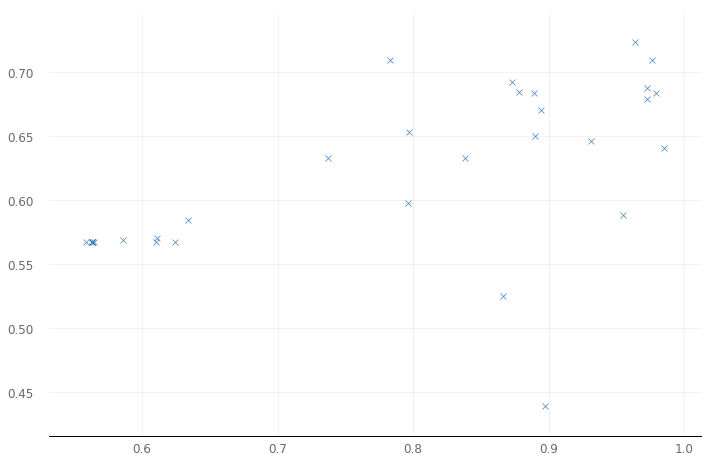

In [100]:
r.plot_regs(x='acc',y='val_acc')

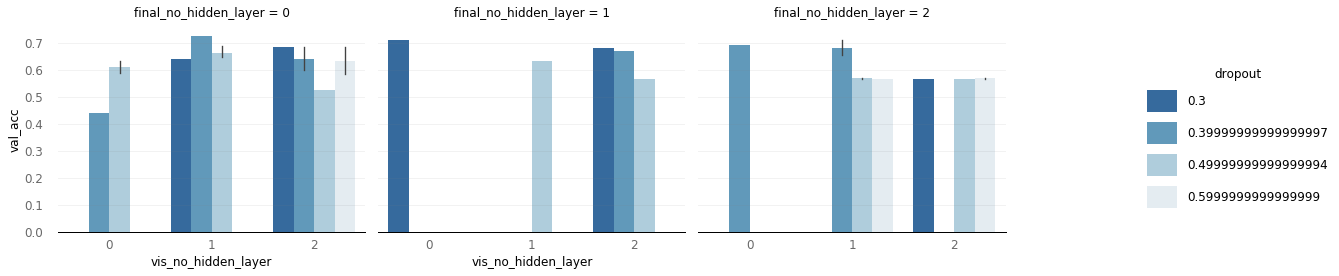

In [103]:
r.plot_bars(x='vis_no_hidden_layer',y='val_acc',hue='dropout',col='final_no_hidden_layer')

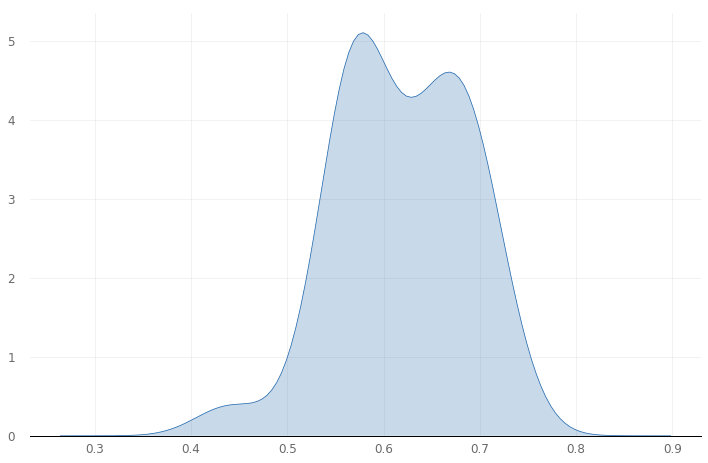

In [108]:
r.plot_kde()

# Hyperparameter experiment no 2

In [124]:
params = {
    'bert_trainable' :[False],
    'text_no_hidden_layer':[0,1],
    'text_hidden_neurons':[768],
    'dropout':[0.4],
    'repr_size':[32],
    'vis_no_hidden_layer':[1],
    'vis_hidden_neurons':[2742],
    'final_no_hidden_layer':[0,1],
    'final_hidden_neurons':[35],
    'optimizer':[tf.keras.optimizers.Adam,tf.keras.optimizers.RMSprop],
    'batch_size':[512],
    'epochs':[10],
    'lr':(0.0001,0.1,10)
}

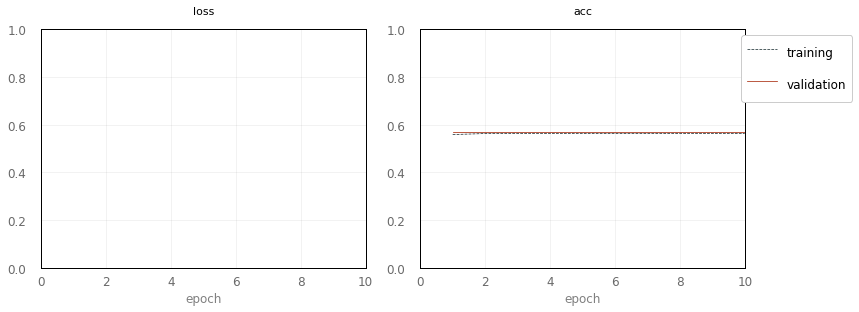


100%|██████████| 40/40 [4:34:48<00:00, 419.05s/it]

In [125]:
h = ta.Scan([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY, params=params,
            model=news_model,
            dataset_name='twitter_fake_news',
            experiment_no='2',
            x_val=[test_input_ids, test_input_masks, test_segment_ids,test_imagesX],
            y_val=testY,
            grid_downsample=.5)

In [126]:
r = ta.Reporting(h)

In [128]:
r.high('val_acc')

0.7346153846153847

In [140]:
r.data.sort_values('val_acc').tail()

,round_epochs,val_loss,val_acc,loss,acc,bert_trainable,text_no_hidden_layer,text_hidden_neurons,dropout,repr_size,vis_no_hidden_layer,vis_hidden_neurons,final_no_hidden_layer,final_hidden_neurons,optimizer,batch_size,epochs,lr
5,10,0.680248,0.676923,0.128123,0.959275,False,0,768,0.4,32,1,2742,0,35,<class 'tensorflow.python.keras.optimizers.Adam'>,512,10,0.00010
34,10,5.140785,0.679808,7.354664,0.542254,False,1,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.Adam'>,512,10,0.07003
23,10,0.656070,0.696154,0.154333,0.950324,False,1,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.Adam'>,512,10,0.00010
25,10,0.675741,0.700962,0.331237,0.851123,False,0,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.RMS...,512,10,0.00010
26,10,0.670797,0.734615,0.283395,0.881927,False,1,768,0.4,32,1,2742,0,35,<class 'tensorflow.python.keras.optimizers.RMS...,512,10,0.00010


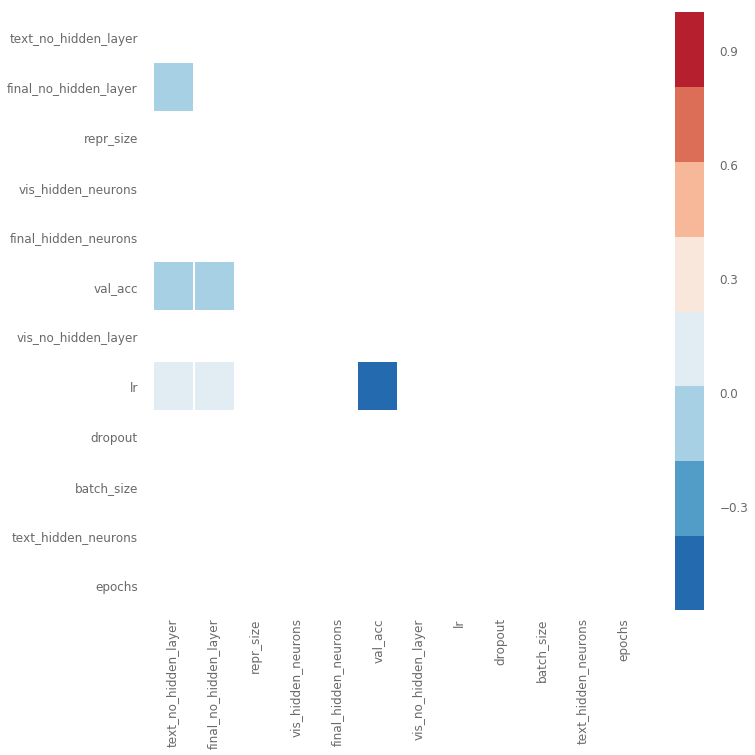

In [141]:
r.plot_corr()

bert_trainable
text_no_hidden_layer
text_hidden_neurons
dropout
repr_size
vis_no_hidden_layer
vis_hidden_neurons
final_no_hidden_layer
final_hidden_neurons
optimizer
batch_size
epochs
lr


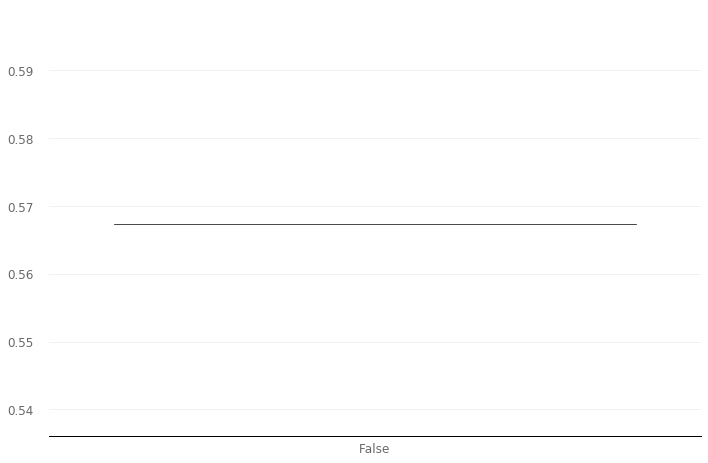

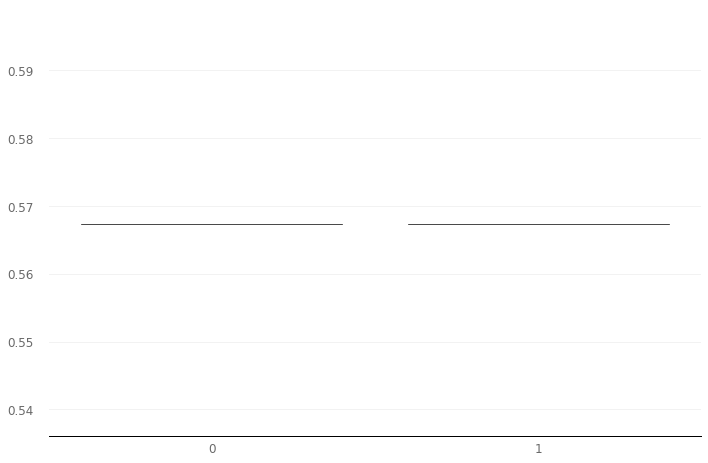

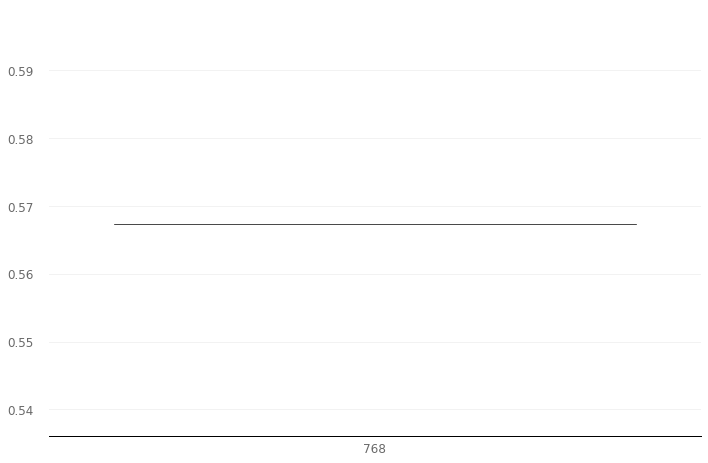

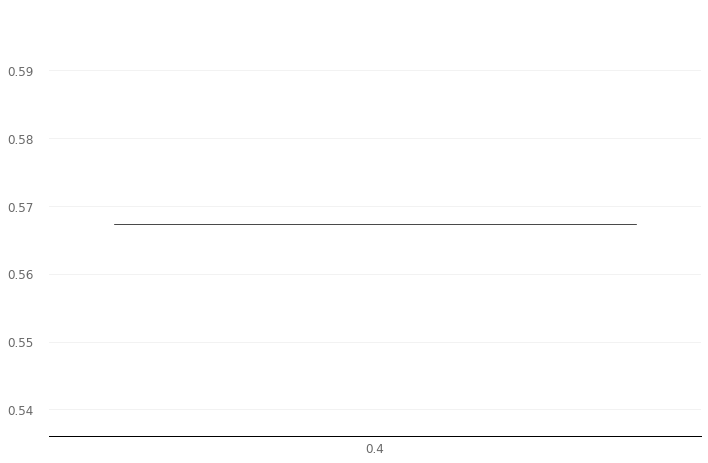

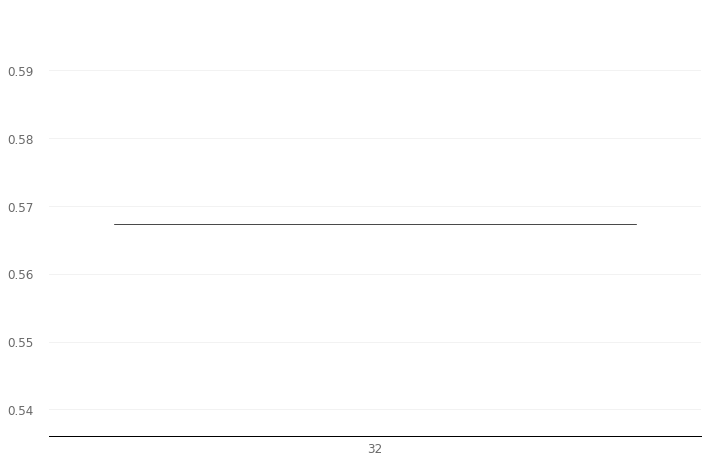

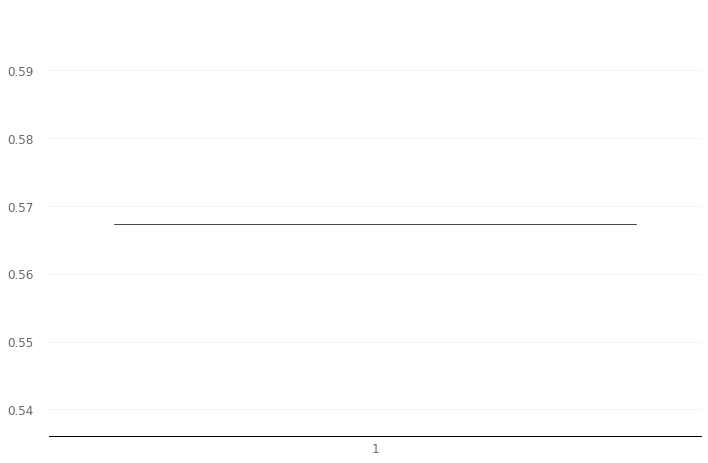

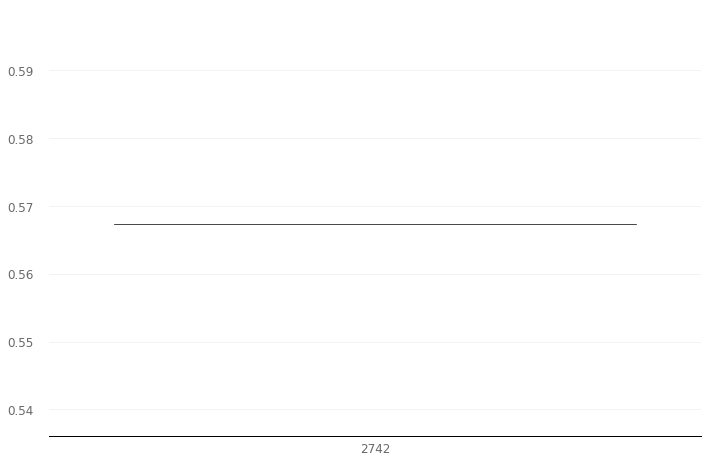

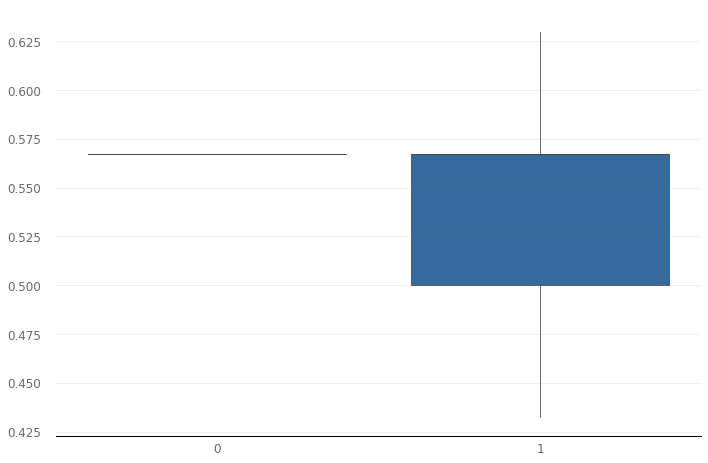

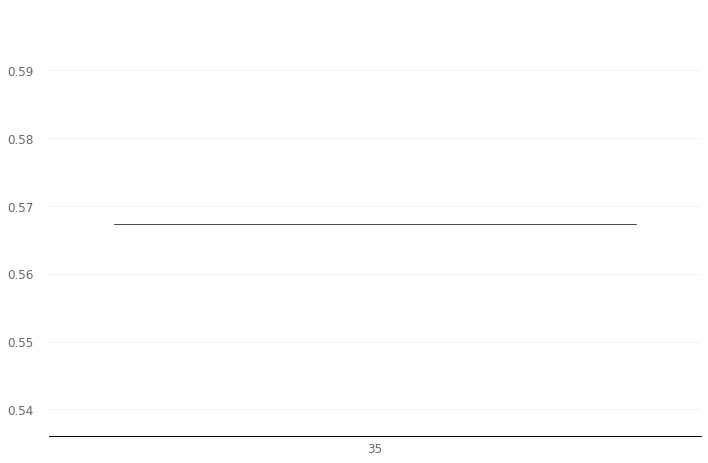

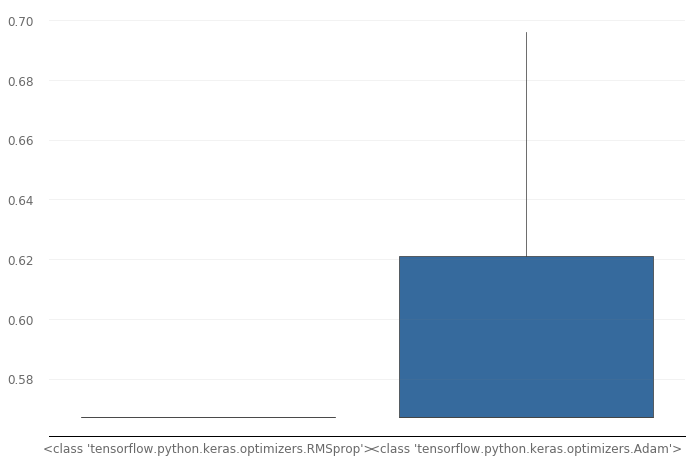

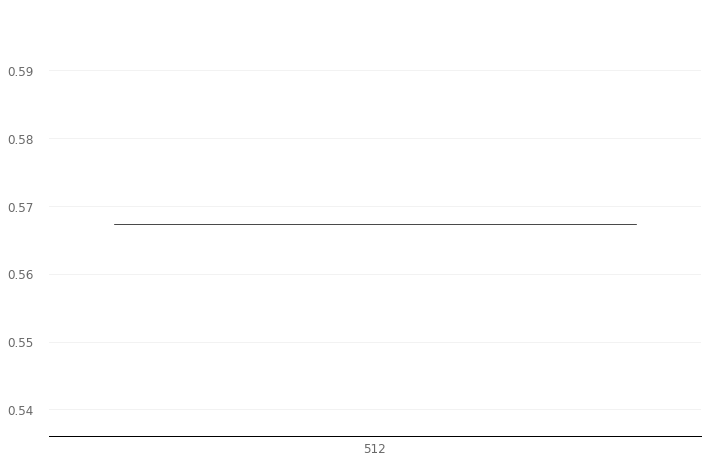

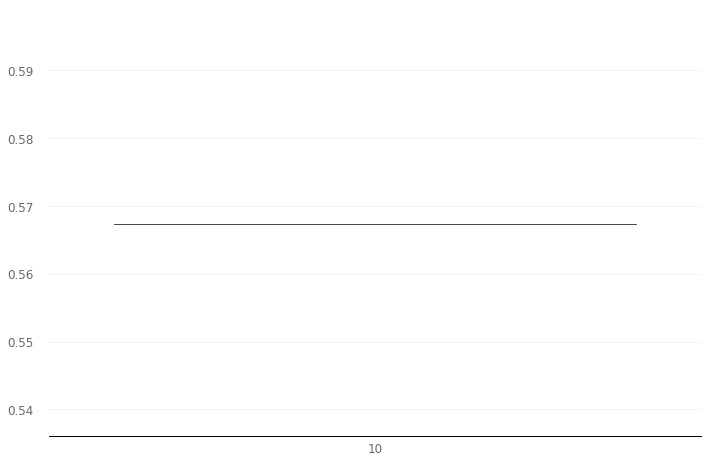

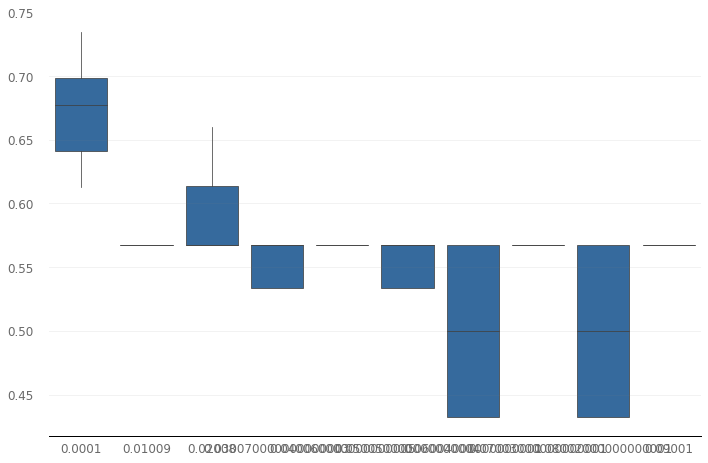

In [136]:
for k in params.keys():
    print(k)
    r.plot_box(y='val_acc',x=k)

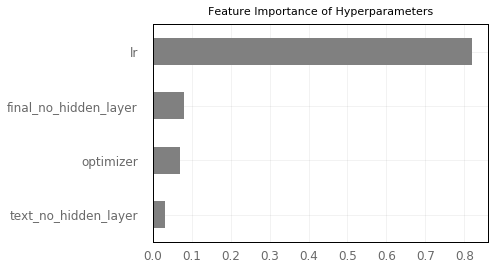

In [142]:
from sklearn.preprocessing import MinMaxScaler

X = r.data[['text_no_hidden_layer','final_no_hidden_layer','optimizer','lr']]
scaler = MinMaxScaler()
y = scaler.fit_transform(r.data[['val_acc']])
X['optimizer'] = pd.factorize(X['optimizer'])[0]
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=3,n_estimators=100)
reg.fit(X,y)
pd.Series(reg.feature_importances_,index=X.columns).\
sort_values(ascending=True).plot.barh(color='grey',title='Feature Importance of Hyperparameters')

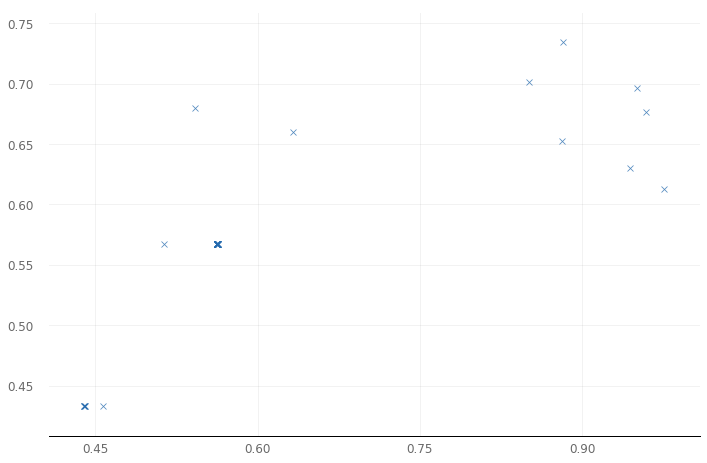

In [143]:
r.plot_regs(x='acc',y='val_acc')

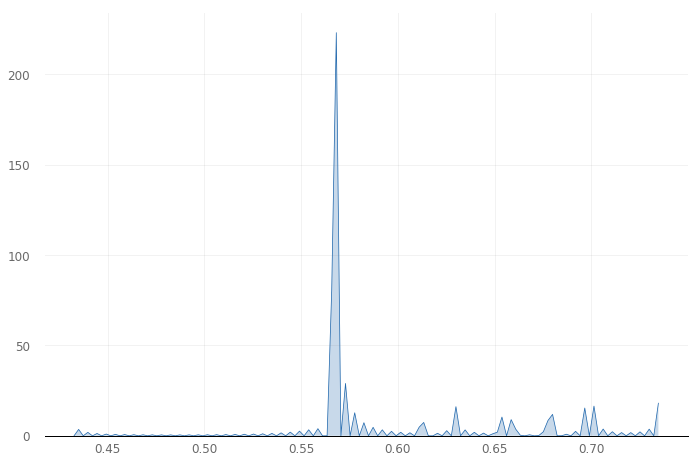

In [149]:
r.plot_kde()

Wring Lr range led to bad results....repeating with confind lr values

Using LR finder to find best learning rate

In [157]:
#text model
def get_news_model( params):
    
#     pprint(params)
    K.clear_session()
    
    with tf.device('/cpu:0'):
        bert_base = BertLayer()
        bert_base.trainable= params['bert_trainable']

        in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
        in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
        in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
        bert_inputs = [in_id, in_mask, in_segment]
        bert_output = bert_base(bert_inputs)

        if params['text_no_hidden_layer']>0:
            for i in range(params['text_no_hidden_layer']):
                bert_output = tf.keras.layers.Dense(params['text_hidden_neurons'], activation='relu')(bert_output)
                bert_output = tf.keras.layers.Dropout(params['dropout'])(bert_output)

        text_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(bert_output)

        #image model
        conv_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(3,224,224))
        conv_base.trainable=False
#         conv_base = base

        input_image = tf.keras.layers.Input(shape=(3,224,224))
        base_output = conv_base(input_image)
        flat = tf.keras.layers.Flatten()(base_output)

        if params['vis_no_hidden_layer']>0:
            for i in range(params['vis_no_hidden_layer']):
                flat = tf.keras.layers.Dense(params['vis_hidden_neurons'], activation='relu')(flat)
                flat = tf.keras.layers.Dropout(params['dropout'])(flat)

        visual_repr = tf.keras.layers.Dense(params['repr_size'],activation='relu')(flat)


        #classifier
        combine_repr = tf.keras.layers.concatenate([text_repr, visual_repr])
        com_drop=tf.keras.layers.Dropout(params['dropout'])(combine_repr)

        if params['final_no_hidden_layer']>0:
            for i in range(params['final_no_hidden_layer']):
                com_drop = tf.keras.layers.Dense(params['final_hidden_neurons'], activation='relu')(com_drop)
                com_drop=tf.keras.layers.Dropout(params['dropout'])(com_drop)

        prediction = tf.keras.layers.Dense(1,activation='sigmoid')(com_drop)

        model = tf.keras.models.Model(inputs=[in_id,in_mask,in_segment,input_image], outputs=prediction)

    model = tf.keras.utils.multi_gpu_model(model,gpus=4)
    
#     if params['optimizer'] == 'adam':
#         opt = tf.keras.optimizers.Adam(lr=0.0005)
#     else:
#         opt = tf.keras.optimizers.RMSprop(lr=0.00005)
        
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'](), metrics=['accuracy'])
    initialize_vars(sess)
    
    
    return model

In [158]:
params_adam = {
    'bert_trainable' :False,
    'text_no_hidden_layer':1,
    'text_hidden_neurons':768,
    'dropout':0.4,
    'repr_size':32,
    'vis_no_hidden_layer':1,
    'vis_hidden_neurons':2742,
    'final_no_hidden_layer':1,
    'final_hidden_neurons':35,
    'optimizer':tf.keras.optimizers.Adam
}

params_rms = {
    'bert_trainable' :False,
    'text_no_hidden_layer':1,
    'text_hidden_neurons':768,
    'dropout':0.4,
    'repr_size':32,
    'vis_no_hidden_layer':1,
    'vis_hidden_neurons':2742,
    'final_no_hidden_layer':1,
    'final_hidden_neurons':35,
    'optimizer':tf.keras.optimizers.RMSprop
}

In [159]:
model_adam=get_news_model(params_adam)

In [160]:
lr_finder = LRFinder(model_adam)

In [161]:
lr_finder.find([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY, 0.000001, 0.01, 512, 5)

Epoch 1/5
13407/13407 [==============================] - 35s 3ms/step - loss: 0.7360 - acc: 0.5073
Epoch 2/5
13407/13407 [==============================] - 27s 2ms/step - loss: 0.6535 - acc: 0.6042
Epoch 3/5
13407/13407 [==============================] - 27s 2ms/step - loss: 0.4836 - acc: 0.7735
Epoch 4/5
13407/13407 [==============================] - 26s 2ms/step - loss: 0.4288 - acc: 0.8142
Epoch 5/5
 3072/13407 [=====>........................] - ETA: 20s - loss: 0.5651 - acc: 0.8122

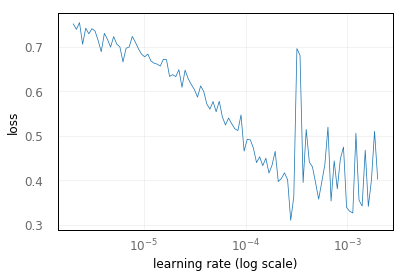

In [162]:
lr_finder.plot_loss()

In [163]:
model_rms=get_news_model(params_rms)

In [164]:
lr_finder = LRFinder(model_rms)

In [165]:
lr_finder.find([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY, 0.000001, 0.01, 512, 5)

Epoch 1/5
13407/13407 [==============================] - 36s 3ms/step - loss: 0.7812 - acc: 0.4868
Epoch 2/5
13407/13407 [==============================] - 28s 2ms/step - loss: 0.6864 - acc: 0.5785
Epoch 3/5
13407/13407 [==============================] - 27s 2ms/step - loss: 0.6805 - acc: 0.6040
Epoch 4/5
13407/13407 [==============================] - 28s 2ms/step - loss: 0.7247 - acc: 0.5587
Epoch 5/5
13407/13407 [==============================] - 28s 2ms/step - loss: 0.8151 - acc: 0.5264


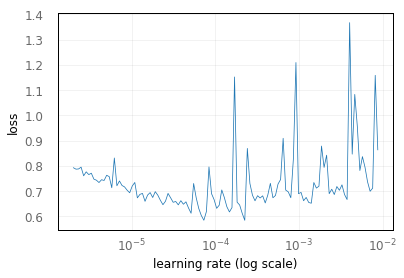

In [167]:
lr_finder.plot_loss()

RE-running LR finder on narrow range

In [173]:
model_adam=get_news_model(params_adam)

In [174]:
lr_finder = LRFinder(model_adam)

In [175]:
lr_finder.find([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY, 0.00005, 0.001, 512, 7)

Epoch 1/7
13407/13407 [==============================] - 37s 3ms/step - loss: 0.6677 - acc: 0.5845
Epoch 2/7
13407/13407 [==============================] - 27s 2ms/step - loss: 0.5492 - acc: 0.6987
Epoch 3/7
13407/13407 [==============================] - 27s 2ms/step - loss: 0.4803 - acc: 0.7498
Epoch 4/7
13407/13407 [==============================] - 27s 2ms/step - loss: 0.3799 - acc: 0.8197
Epoch 5/7
13407/13407 [==============================] - 27s 2ms/step - loss: 0.3127 - acc: 0.8684
Epoch 6/7
13407/13407 [==============================] - 28s 2ms/step - loss: 0.2553 - acc: 0.8971
Epoch 7/7
13407/13407 [==============================] - 28s 2ms/step - loss: 0.2565 - acc: 0.8999


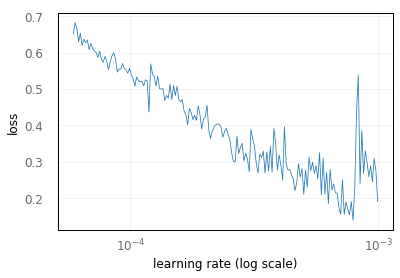

In [176]:
lr_finder.plot_loss()

In [177]:
model_rms=get_news_model(params_rms)

In [178]:
lr_finder = LRFinder(model_rms)

In [179]:
lr_finder.find([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY, 0.00001, 0.001, 512, 8)

Epoch 1/8
13407/13407 [==============================] - 37s 3ms/step - loss: 0.6680 - acc: 0.5911
Epoch 2/8
13407/13407 [==============================] - 28s 2ms/step - loss: 0.5903 - acc: 0.6925
Epoch 3/8
13407/13407 [==============================] - 28s 2ms/step - loss: 0.5627 - acc: 0.7102
Epoch 4/8
13407/13407 [==============================] - 28s 2ms/step - loss: 0.5593 - acc: 0.7160
Epoch 5/8
13407/13407 [==============================] - 28s 2ms/step - loss: 0.5626 - acc: 0.7093
Epoch 6/8
13407/13407 [==============================] - 28s 2ms/step - loss: 0.5798 - acc: 0.6865
Epoch 7/8
13407/13407 [==============================] - 28s 2ms/step - loss: 0.6296 - acc: 0.6698
Epoch 8/8
13407/13407 [==============================] - 28s 2ms/step - loss: 0.6600 - acc: 0.6381


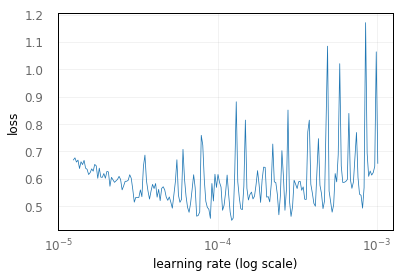

In [180]:
lr_finder.plot_loss()

Hyper parameter experiment to fix batch size mainly

In [199]:
params = {
    'bert_trainable' :[False],
    'text_no_hidden_layer':[1],
    'text_hidden_neurons':[768],
    'dropout':[0.4],
    'repr_size':[32],
    'vis_no_hidden_layer':[1],
    'vis_hidden_neurons':[2742],
    'final_no_hidden_layer':[1],
    'final_hidden_neurons':[35],
    'optimizer':[tf.keras.optimizers.Adam],
    'batch_size':[128,256,512],
    'epochs':[10],
    'lr':[0.00005,0.0005,0.00075]
}

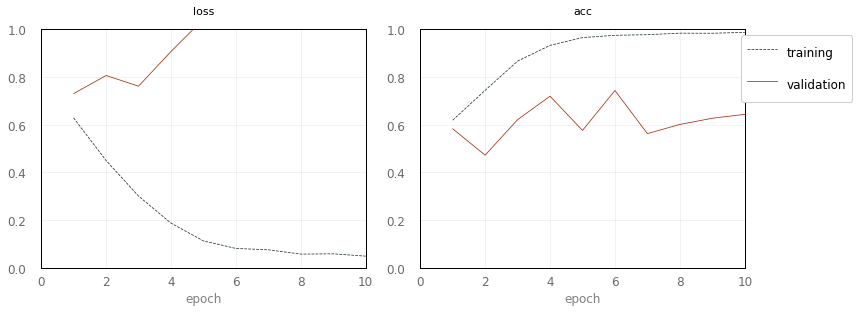





100%|██████████| 9/9 [1:05:08<00:00, 433.76s/it]

In [200]:
h = ta.Scan([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY, params=params,
            model=news_model,
            dataset_name='twitter_fake_news',
            experiment_no='3',
            x_val=[test_input_ids, test_input_masks, test_segment_ids,test_imagesX],
            y_val=testY)

In [201]:
r = ta.Reporting(h)

In [202]:
r.high('val_acc')

0.7480769230769231

In [204]:
r.data.sort_values('val_acc')

,round_epochs,val_loss,val_acc,loss,acc,bert_trainable,text_no_hidden_layer,text_hidden_neurons,dropout,repr_size,vis_no_hidden_layer,vis_hidden_neurons,final_no_hidden_layer,final_hidden_neurons,optimizer,batch_size,epochs,lr
0,10,0.684112,0.567308,0.585147,0.568360,False,1,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.Adam'>,256,10,0.00075
5,10,0.690176,0.616346,0.288019,0.892743,False,1,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.Adam'>,512,10,0.00075
4,10,0.757478,0.671154,0.091138,0.975386,False,1,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.Adam'>,128,10,0.00005
7,10,0.693186,0.689423,0.211171,0.926680,False,1,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.Adam'>,512,10,0.00005
6,10,0.662417,0.704808,0.127978,0.957858,False,1,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.Adam'>,512,10,0.00050
1,10,0.695243,0.713462,0.148110,0.947341,False,1,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.Adam'>,128,10,0.00075
3,10,0.722816,0.730769,0.116719,0.966659,False,1,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.Adam'>,256,10,0.00005
8,10,0.730194,0.743269,0.048878,0.986947,False,1,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.Adam'>,128,10,0.00050
2,10,0.702392,0.748077,0.322046,0.879690,False,1,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.Adam'>,256,10,0.00050


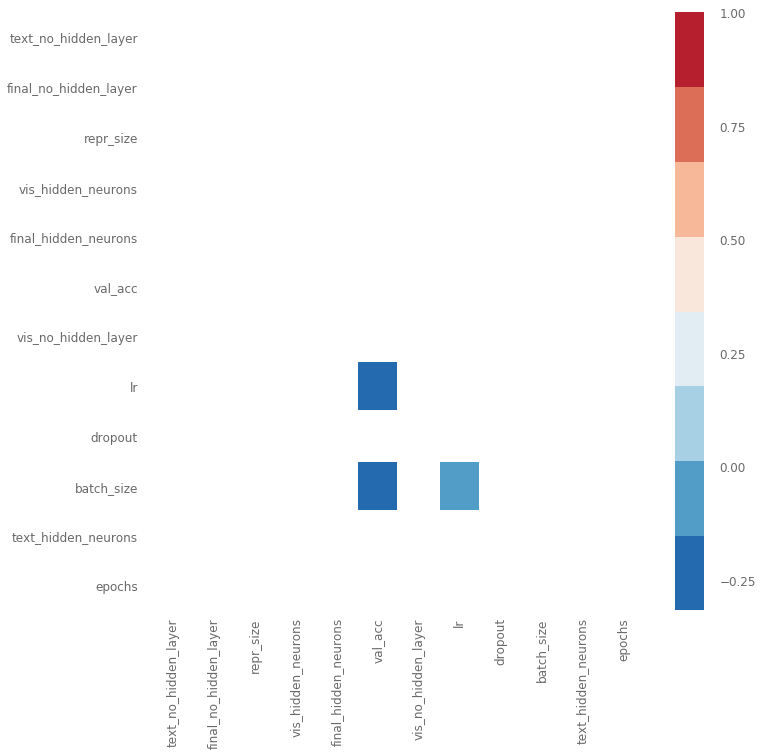

In [205]:
r.plot_corr()

batch_size
lr


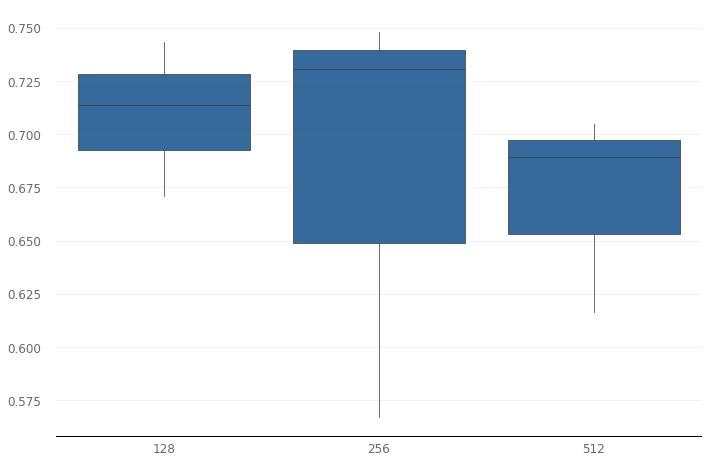

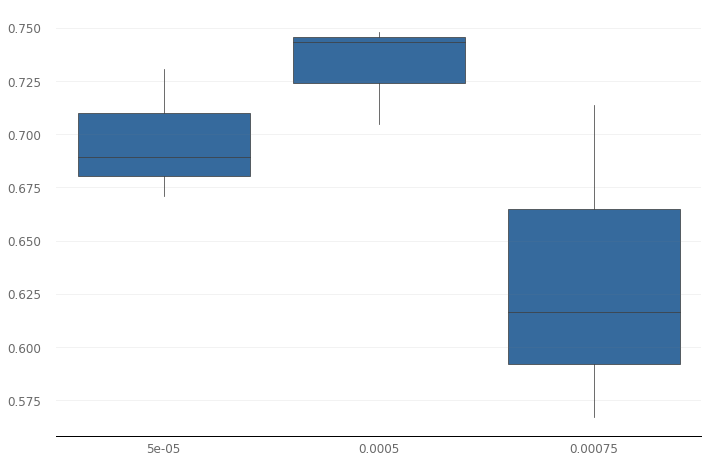

In [206]:
for k in ['batch_size','lr']:
    print(k)
    r.plot_box(y='val_acc',x=k)

Lets just try to train best two models

In [207]:
r.data.sort_values('val_acc')

,round_epochs,val_loss,val_acc,loss,acc,bert_trainable,text_no_hidden_layer,text_hidden_neurons,dropout,repr_size,vis_no_hidden_layer,vis_hidden_neurons,final_no_hidden_layer,final_hidden_neurons,optimizer,batch_size,epochs,lr
0,10,0.684112,0.567308,0.585147,0.568360,False,1,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.Adam'>,256,10,0.00075
5,10,0.690176,0.616346,0.288019,0.892743,False,1,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.Adam'>,512,10,0.00075
4,10,0.757478,0.671154,0.091138,0.975386,False,1,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.Adam'>,128,10,0.00005
7,10,0.693186,0.689423,0.211171,0.926680,False,1,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.Adam'>,512,10,0.00005
6,10,0.662417,0.704808,0.127978,0.957858,False,1,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.Adam'>,512,10,0.00050
1,10,0.695243,0.713462,0.148110,0.947341,False,1,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.Adam'>,128,10,0.00075
3,10,0.722816,0.730769,0.116719,0.966659,False,1,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.Adam'>,256,10,0.00005
8,10,0.730194,0.743269,0.048878,0.986947,False,1,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.Adam'>,128,10,0.00050
2,10,0.702392,0.748077,0.322046,0.879690,False,1,768,0.4,32,1,2742,1,35,<class 'tensorflow.python.keras.optimizers.Adam'>,256,10,0.00050


In [238]:
params_final = {
    'bert_trainable' :False,
    'text_no_hidden_layer':1,
    'text_hidden_neurons':768,
    'dropout':0.4,
    'repr_size':32,
    'vis_no_hidden_layer':1,
    'vis_hidden_neurons':2742,
    'final_no_hidden_layer':1,
    'final_hidden_neurons':35,
    'optimizer':tf.keras.optimizers.Adam
}

In [239]:
model=get_news_model(params_final)

In [240]:
K.set_value(model.optimizer.lr, 0.0005)

In [241]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model-{epoch:03d}-{val_acc:03f}.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='max')  

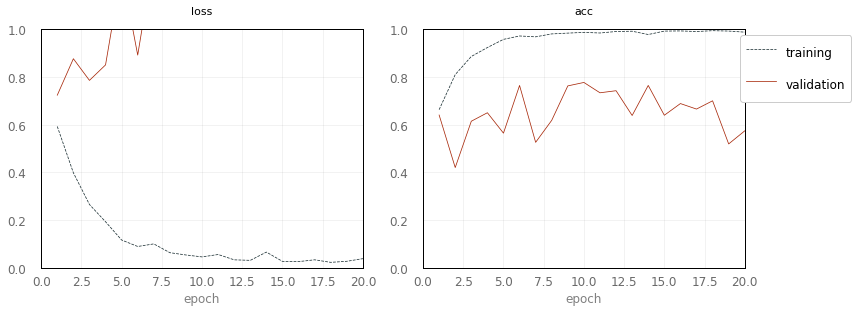


Epoch 00020: val_acc did not improve from 0.77692


In [242]:
out = model.fit([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY,
                    batch_size=256,
                    epochs=20,
                    verbose=0,
                    shuffle=True,
                    validation_data=([test_input_ids, test_input_masks, test_segment_ids,test_imagesX],testY),callbacks=[live(),checkpoint])

In [243]:
model=get_news_model(params_final)

In [244]:
model.load_weights('model-010-0.776923.h5')

In [245]:
test_predict = model.predict([test_input_ids, test_input_masks, test_segment_ids,test_imagesX])
test_predict = [1 if i>=0.5 else 0 for i in test_predict]

In [246]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score


In [247]:
print(f'Accuracy == {accuracy_score(testY,test_predict)}')
print(f'F1 == {f1_score(testY,test_predict,average=None)}')
print(f'Precision == {precision_score(testY,test_predict,average=None)}')
print(f'Recall == {recall_score(testY,test_predict,average=None)}')

Accuracy == 0.7769230769230769
F1 == [0.8218126  0.70179949]
Precision == [0.75140449 0.83231707]
Recall == [0.90677966 0.60666667]


In [156]:
# results = dict()
# for i in tqdm(range(20)):
#     p = dict()
#     for k,v in params.items():
#         p[k] = choice(v)
        
#     history,model = news_model([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY, [test_input_ids, test_input_masks, test_segment_ids,test_imagesX],testY,p)
#     val_loss, val_acc = model.evaluate([test_input_ids, test_input_masks, test_segment_ids,test_imagesX],testY,verbose=0)
# #     train_loss,train_acc = model.evaluate([train_input_ids, train_input_masks, train_segment_ids,train_imagesX],trainY)
  
#     results[i] = {'p':p,'val_loss':val_loss,'val_acc':val_acc,'history':history}
# start=0.001
# end=0.01
# n=4
# np.arange(start, end, (end - start) / n, dtype=float)/100

In [43]:
# K.clear_session()

In [44]:
# lr_finder = LRFinder(model)

In [45]:
# lr_finder.find([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY, 0.0000001, 1, 512, 8)

In [46]:
# lr_finder.plot_loss()

In [47]:
# lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5)

In [48]:
# K.set_value(model.optimizer.lr, 0.00005)

In [49]:
# history = model.fit([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY, validation_data=([test_input_ids, test_input_masks, test_segment_ids,test_imagesX],testY),shuffle= True, epochs=10, batch_size=512)

In [50]:
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.axhline(y=0.76,linewidth=1, color='r')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [51]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# # plt.ylim((0,1))
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [52]:
# model.evaluate([test_input_ids, test_input_masks, test_segment_ids,test_imagesX],testY)

In [53]:
# model.evaluate([train_input_ids, train_input_masks, train_segment_ids,train_imagesX],trainY)